# Homework - Cancer Classification over Distributed Networks
**Student:** Francesco Fabbri

# Introduction
In this work, given the cancer dataset, we want to predict if a detected cancer is malignant or benign. This binary classification problem is approached through a distributed version of a well-known classifier, Support Vector Machine (SVM), on a sparse geometric random graph. Distributing the SVM classifier means solving an optimization problem, which is solved computing from scratch a sub-gradient algorithm. We apply the algorithm on the 70% of the data (training set) and evaluate then its performance on the remaining 30%. Afterwards, the obtained results are compared to the classical version of SVM, in order to check whether there are some differecens among the 2 predictions.

In [1]:
### Libs ###
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
from networkx.generators.geometric import random_geometric_graph
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC  
import random, warnings
warnings.filterwarnings('ignore')

# Data

The dataset is composed by 683 observations and 10 variables (9 covariates and the target variable). We split the data, using 478 obs as train set and 205 as test set (split 70/30).

In [2]:
# Import Data and split train/test
df = pd.read_csv('breast_cancer.csv', index_col=0)
df.Class.loc[df.Class == 'benign'] = -1
df.Class.loc[df.Class == 'malignant'] = 1
df = df[df.columns[1:]]
df.columns = [x.lower().replace('.', '_') for x in df.columns]
df = df.rename(columns = {'class':'y'})
df.dropna(inplace=True)
df.index = range(len(df))
split_ = int(len(df)*0.7)
train = df.iloc[:split_]
test = df.loc[split_:]

print df.shape
print 'Train: ' + str(len(train)) + ' obs'
print 'Test: ' + str(len(test)) + ' obs'

df.head()

(683, 10)
Train: 478 obs
Test: 205 obs


,cl_thickness,cell_size,cell_shape,marg_adhesion,epith_c_size,bare_nuclei,bl_cromatin,normal_nucleoli,mitoses,y
0,5,1,1,1,2,1.0,3,1,1,-1
1,5,4,4,5,7,10.0,3,2,1,-1
2,3,1,1,1,2,2.0,3,1,1,-1
3,6,8,8,1,3,4.0,3,7,1,-1
4,4,1,1,3,2,1.0,3,1,1,-1


The graph is connected: True
Avg. Degree: 3.25


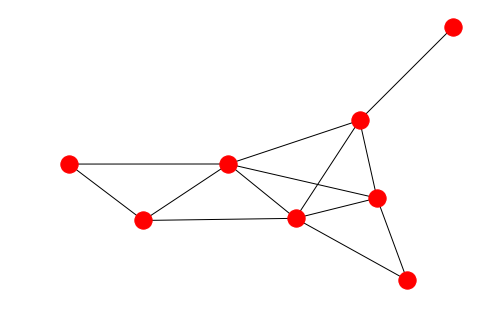

In [3]:
# Random Sparse Geometric Graph
random.seed(111)
N_agents = 8
conn = False
count_g = 101
lst_graphs = []
while True:
    rad = np.sqrt(2.0*np.log(N_agents)/(N_agents*np.pi))
    G = random_geometric_graph(n=N_agents, radius=rad ,dim=2)
    if nx.is_connected(G) is True:
        lst_graphs.append(G.copy())
    if len(lst_graphs) == count_g:
        break
avg_degree = np.array([np.mean(g.degree()) for g in lst_graphs])
idx_med = [idx for idx, x in enumerate(avg_degree) if x <= np.median(lst_graphs)][0]
# we took the graph with avg_degree <= median of 100 geometric random graphs
G = lst_graphs[idx_med]
print 'The graph is connected: %s'%nx.is_connected(G)
print 'Avg. Degree: %s'%np.mean(dict(G.degree()).values())

nx.draw(G)
plt.show()

# Problem Formulation
**Graph.** In order to build a sparse network we build a random sparse geometric graph with 8 nodes (avg. degree 3.25). Each processor has to deal with a subset of the training data (59 obs for each one). 

**L2-SVM.** Our binary classication task can be solved starting from the definition of L2 - SVM:

$$\min_{w,b}{\frac{1}{N} \sum_i^N \max \big (0, 1 - y_i (\textbf{w}^T \textbf{x_i} - b) \big )} + \lambda ||\textbf{w}||_2^2 $$

We can then write the distributed version of the problem, with M as the number of agents:

$$\min_{w,b}{\frac{1}{N} \sum_{j = 1}^M \sum_{i \in n_j} \Big ( \max \big (0, 1 - y_i (\textbf{w}^T \textbf{x}_i - b) \big )} + \lambda ||\textbf{w}||_2^2 \Big )$$

Focusing on the term involved in the hinge-loss function $y_i (\textbf{w}^T \textbf{x} - b)$, we can introduce $\textbf{z} = (\textbf{w}, b)$. Using $\textbf{z}$ we can write the covariates as $a_i = (\textbf{x}, - 1)$ and then state the previous problem as:

$$\min_{w,b}{\frac{1}{N} \sum_{j = 1}^M \sum_{i \in n_j} \Big ( \max \big (0, 1 - y_i (\textbf{a}_i^T \textbf{z}) \big )} + \lambda ||\textbf{z}||_2^2 \Big )$$

# Algorithm

In the distributed architecture just initialized, even though each node communicates only with his neighbors, applying the sub-gradient algorithm is possible to reach the consensus. Since the hinge-loss function is not differentiable, we need to apply the sub-gradient algorithm to solve our problem.

With:

- A = adjacency matrix and D diagonal matrix of the degress, we can define the Laplacian L as L = D - A

- $\mu[n] = \frac{\mu_0}{k^{\gamma}} $ as step size of the algorithm

- $\mu_0 \in (0,1)$ and $\gamma \in (0.5, 1]$ parameters involved in the computation of $\mu[n]$

- $W = I - \varepsilon L$

- $\varepsilon \in \big (0, \frac{2}{\lambda_{max}(L)} \big )$

- M number of nodes


We have:

$$z_j [n+1] = \sum_{j=1}^{M} z_j[n] w_j - \mu_j[n] \Big ( \sum_{i \in n_j} \frac{\partial f_{z_i}(a_i) }{\partial z} + \nabla g(z[n])  \Big )$$

Where the subgradient of the hinge-loss can be computed as:

$$\frac{\partial f}{\partial z} =\begin{cases} 0 & y_i(\textbf{a}_i \textbf{z}_i) < 1\\
                     -y_i\textbf{a}_i & y_i(\textbf{a}_i \textbf{z}_i) \geq 1
       \end{cases}$$




In [4]:
### assocation (agent, portion of data) ###
agent_association = {k: [] for k in G.nodes.keys()}

idxs_obs = train.index.values.tolist()
n = 0
size_agent = int(len(train)/N_agents)
while idxs_obs != []:
    lst = idxs_obs[:size_agent]
    idxs_obs = idxs_obs[size_agent:]
    agent_association[n] = agent_association[n] + lst
    n +=1
    if n == N_agents:
        n = 0

# Laplace and W matrix
# W = I - \eps L
# \eps = 0 < \eps < 2/\lambda_{max}(L)
L = nx.laplacian_matrix(G)
L = L.todense()
eps = 1/max(np.linalg.eigvals(L))
W = np.identity(N_agents) - eps*L

print "Number of features: %s"%(df.shape[1] - 1)
print "Number of clusters: %s"%N_agents

Number of features: 9
Number of clusters: 8


In [5]:
### Functions for distributed classifier ###
def gradient_regularizer(z_i):
    return 2*z_i

def update_mu(mu_0, k, gamma):
    return 1.0*mu_0/(k**gamma)

# hinge-loss function
def subgradient_hingeloss(idx_node, agent_association, y, x_matrix,z_matrix):
    res = np.zeros(z_matrix.shape[0])
    for one_obs in agent_association[idx_node]:  
        x_obs = x_matrix.loc[one_obs].values
        z_array = z_matrix[:,idx_node]
        one_y = y.loc[one_obs].values[0]
        condition = one_y*np.dot(x_obs, z_array)
        if condition < 1:
            one_res = -one_y*x_obs
            res += one_res 
        else:
            pass
    return res

In [6]:
### Run Distributed SVM ###

# train
x_train = train[train.columns[:-1]]
x_train['b'] = +1
n_features = x_train.shape[1]
y_train = train[[train.columns[-1]]]

# test
x_test = test[test.columns[:-1]]
x_test['b'] = +1
y_test = test[[test.columns[-1]]]

# weights
z_matrix = np.zeros((n_features, N_agents))
# improving performance reducing mu and increasing gamma
mu_0 = 0.1
gamma = 0.95
count = 500
k = 1
history_z = {ag : [] for ag in range(N_agents)}
history_main = []
# main loop
while True:
    history_main.append(z_matrix.copy())
    for selected_agent in range(N_agents):
        z_new =  np.reshape(np.dot(z_matrix,W[:,selected_agent]), (n_features,))
        mu_k = update_mu(mu_0, k, gamma)
        sub_hl = subgradient_hingeloss(selected_agent, agent_association, y_train, x_train, z_matrix)
        grad_reg = gradient_regularizer(z_matrix[:,selected_agent])
        z_new = z_new - mu_k*(sub_hl + grad_reg)
        z_matrix[:,selected_agent] =z_new
        history_z[selected_agent].append(z_new) 
    k +=1
    if k == count:
        break

# Classic SVM

In [7]:
### classic SVM ###
svclassifier = SVC(kernel='linear')  
svclassifier.fit(x_train, y_train)  
y_pred = svclassifier.predict(x_test)  
acc_classic_model = accuracy_score(y_test.values, y_pred)

# Comparison and Results

**Accuracy.** Now, in order to evaluate our prediction, we compare the accuracy of the two models: for the distributed one, we compute the average of the accuracy of the 8 different $\textbf{z}_i$ over the test. As we can see in the results below, the 2 values are quite similar. Moreover, in order to analyze the behavior of the algorithm, we plot the accuracy obtained at each step: as we can see from the plot, it becomes quite stable after 400 iterations.

**Disagreement.** Another diagnostic plot useful to study the goodness of our results it's the computation of the disagreement along the run. As shown below, it becomes quite stable after not so many steps.

Classic: 0.9902439024390244
Distributed: 0.9908536585365854


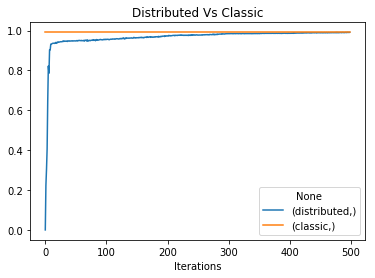

In [8]:
# accuracy over the test
def test_accuracy(N_agents, z_matrix, x_test, y_test):
    accuracy = {agent : 0 for agent in range(N_agents)}
    for selected_agent in accuracy:
        estimates = []
        for obs in x_test.values:
            est = np.dot(z_matrix[:-1,selected_agent], obs[:-1])
            est = est + z_matrix[-1, selected_agent]
            estimates.append(est)
        right_pred = filter(lambda x: np.sign(x[0]) == np.sign(x[1]),
                           zip(y_test['y'].values,estimates ))
        accuracy[selected_agent] = 1.0*len(right_pred)/test.shape[0]
    return np.mean(accuracy.values())

### Comparison of Results ###
res = [test_accuracy(N_agents, one_z, x_test, y_test) for one_z in history_main]
evaluation = pd.DataFrame(data=[res], index=[['distributed']]).T
evaluation['classic'] = acc_classic_model
print 'Classic: %s'%acc_classic_model
print 'Distributed: %s'%res[-1]
evaluation.plot()
plt.xlabel('Iterations')
plt.title('Distributed Vs Classic')
plt.show()

In [9]:
# avg_disagreement
def compute_disagreement(history_):
    over_k = []
    for m in history_:
        disagreement_among_cov = N_agents*np.var(m,axis = 1)
        val = np.mean(disagreement_among_cov)
        over_k.append(val)
    return over_k

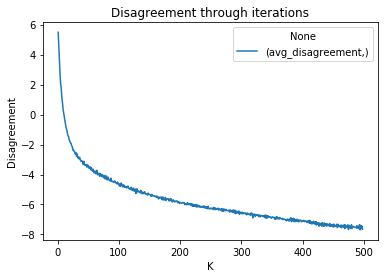

In [10]:
avg_disagreement = pd.DataFrame(data=[compute_disagreement(history_main)],
                          index=[['avg_disagreement']]).T
avg_disagreement['avg_disagreement'].apply(np.log).plot()
plt.xlabel('K')
plt.ylabel('Disagreement')
plt.title('Disagreement through iterations')
plt.show()